In [21]:
%matplotlib inline
#from __future__ import division
import numpy as np
import glob
import pylab as plt
from astropy.io import fits
import astropy
import barycorrpy
from scipy.signal import medfilt
from scipy.signal import savgol_filter
from scipy.signal import argrelmax
from scipy.signal import peak_widths

Working on the coordinate array to make pointing more automatic.
I was thinking maybe we can for loop this into the pointing somehow.

Like in the data acquisition section for-looping through the coordinates and maybe using the coordinates in the filename to easily distinguish them as well.

In [87]:
def get_projected_velocity(ra, dec, jd, obs_lat=37.9183, obs_lon=-122.1067, 
        obs_alt=304, epoch=2451545.):
    '''Compute the projected velocity of the telescope wrt the 
    Local Standard of Rest.
    Parameters
    ----------
    ra, dec : float degrees, the RA/DEC of target
    jd      : float, julian date (UTC) of the observation
    obs_lat : float degrees, latitude of observatory, default=nch.lat
    obs_lon : float degrees, longitude of observatory, default=nch.lon
    obs_alt : float meters, altitude of observatory, default=nch.alt
    epoch   : float, julian date epoch of ra/dec coordinates
              default=2451545 is J2000
    Returns
    -------
    v : float m/s, barycenter-corrected radial velocity,
        see (Wright & Eastman, 2014) '''
    jd_utc = astropy.time.Time(jd, format='jd', scale='utc')
    proper_motion_ra = 0. # proper motion in ra, mas/yr
    proper_motion_dec = 0. # proper motion in dec, mas/yr
    parallax = 0. # parallax of target in mas
    rv = 0. # radial velocity of target in m/s
    zmeas = 0. # measured redshift of spectrum
    ephemeris = 'de430' # ephemeris from jplephem, ~100MB download first use
    v, warn, flag = barycorrpy.get_BC_vel(JDUTC=jd_utc, ra=ra, dec=dec, 
        lat=obs_lat, longi=obs_lon, alt=obs_alt,
        pmra=proper_motion_ra, pmdec=proper_motion_dec,
        px=parallax, rv=rv, zmeas=zmeas,
        epoch=epoch, ephemeris=ephemeris, leap_update=False)
    return v

TESTING CODE FOR FUTURE USE ONCE WE HAVE DATA

In [837]:
#making two arrays each representing galactic coordinates (l,b)
l = np.linspace(60, 110, 26)
b = np.linspace(-90, -30, 31)

In [388]:
print(l)

[ 60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.  84.  86.
  88.  90.  92.  94.  96.  98. 100. 102. 104. 106. 108. 110.]


In [838]:
#list that will hold the coordinates for the observation
coords = []
#counter to make sure that every other value needs to be reversed. Used in the forloop below
N = 1

#for loop that loops through the coordinates and assigns them to the coords list
for i in range(len(l)):
    
    for j in range(len(b)):
        
        #this if statement checks to see if the N value is divisible by 2 we do this to
        #flip the order of the vertical component of the observation 
        if N % 2 == 0:
            
            coords.append(np.array([l[i], b[-1 * (j+1)]]))
        
        else:
            coords.append(np.array([l[i], b[j]]))
    
    #increments the counter        
    N += 1    

In [839]:
#me checking to see if the for loop did its job i should expect to see
#    [60, -30]
#    [62, -30]
# 
#    [62, -90]
#    [64, -90]
#
#Which I see and that is very awesome :D!!!
#FIERRROOOO!!!!!!!!!!!

#MUST EMPHASIZE THIS USES GALACTIC COORDINATES BUT SHOULD BE EASY TO TRANSLATE INTO (RA,DEC)

#for i in coords:
#    print(i)

print(len(coords))

806


This is gonna be where I work on the 2D data for when we have the Magellenic data.

This is gonna be the matrix that has b-rows and l-columns.

b by l

In [195]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

In [196]:
plt.rc('font', **font)

In [197]:
ll, bb = np.meshgrid(l,b)

In [7]:
print('row: ', len(bb[:,0]))
print('column: ', len(bb[0,:]))

row:  31
column:  26


MAKING AN EMPTY MATRIX WITH THE SAME ROW AND COLUMNS AS ABOVE

THIS WILL HOLD THE INFORMATION FOR THE DATA GATHERED FROM OUR OBSERVATIONS

In [8]:
matrix = np.zeros((31,26))

In [198]:
#MAKING TWO LISTS ONE THAT HOLDS THE GALACTIC COORDINATES LABELED AS:
#lb_val
#AND ANOTHER ONE CALLED INDEXES WHICH IS WHERE THE INDEX ARE IN THE MESHGRID ARRAY

lb_val = []
indexes = []

for i in range(len(ll[:,0])):
    for j in range(len(bb[0,:])):
        
        #HOLDING THE ROW INDEX
        row = i
        #HOLDS THE COLUMN INDEX
        column = j
        
        #HOLDS THE INDEX IN A LIST
        index = [i,j]
        
        #APPENDING THE VALUE FOR LL AND BB INTO THE [L,B] GALACTIC COORDINATES
        lb_val.append([ll[i,j], bb[i,j]])
        indexes.append(index)

In [221]:
#for i in range(len(lb_val)):
 #   print(lb_val[i], indexes[i])

INITIAL TRY TO SET UP SOME MAPPING STRUCTURE

Text(0, 0.5, 'Galactic Latitude (b)')

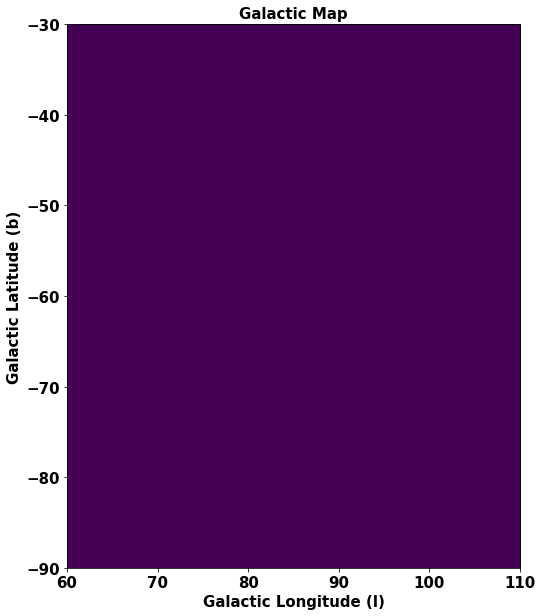

In [72]:
plt.figure(figsize = (10,10))
plt.title('Galactic Map', fontsize = 15, weight = 'semibold')
plt.imshow(matrix, origin = 'lower', extent=[60,110,-90,-30])
plt.xlabel('Galactic Longitude (l)', fontsize = 15, weight = 'semibold')
plt.ylabel('Galactic Latitude (b)', fontsize = 15, weight = 'semibold')

Making functions that automates the data collection and places them into the respective latitude and longitude on the imshow plot

For us our data will be in the form of jddd.ddd.l.b.fits

What we are interested in is extracting the l and b from the fits name so that we can correctly place them in the plots

In [74]:
#The code below extracts all the fits files from the directory into the variable name files

In [5]:
files = np.sort(np.array([f for f in glob.glob("*.fits")]))

In [6]:
print(files)

['2458597.01482.60.0.-30.0.fits' '2458597.01482.60.0.-32.0.fits'
 '2458597.01482.60.0.-34.0.fits' '2458597.01482.60.0.-36.0.fits'
 '2458597.01482.60.0.-38.0.fits' '2458597.01482.60.0.-40.0.fits'
 '2458597.01482.60.0.-42.0.fits' '2458597.01482.60.0.-44.0.fits'
 '2458597.01482.60.0.-46.0.fits' '2458597.01482.60.0.-48.0.fits'
 '2458597.01482.60.0.-50.0.fits' '2458597.01482.60.0.-52.0.fits'
 'noise_off.fits' 'noise_on.fits']


Getting the calibration data files and making them into its own variable

In [7]:
cal_files = ['noise_off.fits', 'noise_on.fits']

In [8]:
#making a noise filter array to get rid of the calibration data
noise_file_filter = np.ones(len(files), dtype = bool)

#making a for loop that goes through the files and gets rid of these files from the list
for i in range(len(files)):
    
    if cal_files[0] == files[i]:
        noise_file_filter[i] = False
    if cal_files[1] == files[i]:
        noise_file_filter[i] = False

spec_files = files[noise_file_filter]

In [9]:
#checking to see if the filter only gave us the files of the spectrum

In [10]:
print(spec_files)

['2458597.01482.60.0.-30.0.fits' '2458597.01482.60.0.-32.0.fits'
 '2458597.01482.60.0.-34.0.fits' '2458597.01482.60.0.-36.0.fits'
 '2458597.01482.60.0.-38.0.fits' '2458597.01482.60.0.-40.0.fits'
 '2458597.01482.60.0.-42.0.fits' '2458597.01482.60.0.-44.0.fits'
 '2458597.01482.60.0.-46.0.fits' '2458597.01482.60.0.-48.0.fits'
 '2458597.01482.60.0.-50.0.fits' '2458597.01482.60.0.-52.0.fits']


CODE BLOCKS BELOW ARE THERE FOR ME TO SEE WHAT IS IN THE HEADER

In [92]:
#getting an hdu object from the files to check on the header
hd = fits.open(files[0])
hdr = hd[0].header

In [93]:
print(repr(hdr))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
NSPEC   =                  500 / Number of spectra recorded                     
BOFFILE = 'spec_ds8_8192.bof'  / FPGA binary code                               
MODE    = 'spec    '           / Spectrometer mode                              
FPGA    =          192000000.0 / FPGA clock speed (Hz)                          
IADC    =          768000000.0 / iADC clock speed (Hz)                          
DOWNSAMP=                    8 / ADC downsampling period.                       
SAMPRATE=           24000000.0 / Downsampled clock speed (Hz)                   
BW      =           12000000.0 / Bandwidth of spectra (Hz)                      
NCHAN   =                 81

CONTINUATION OF ME MAKING FUNCTIONS FOR THE PROJECT

---

GAIN FUNCTION

In [15]:
def Gain(s_cal, s_cold):
    
    '''
    Function that calculates the gain for the telescope
    
    Parameters
    ------------
    s_cal: calibrated data, this should be the one with the noise added
    s_cold: non-calibrated data just the telescope pointing in an arbitrary direction
    
    Ouptut
    ------------
    G: the gain calculated for the telescope which we multiply all our power spectrum by
    '''

    #the temperature we used for the calibration we we use as 30K for the T_cal and T_cold as space 2.73K       
    T_cal = 30
    T_cold = 2.73

    #getting the difference
    diff = s_cal-s_cold

    #calculating the Gain
    G = ((T_cal - T_cold)/(np.sum(diff))) * np.sum(s_cold)
    
    return G

In [16]:
def Num_Spec(hdu):
    
    '''
    Function that returns the number of spectrums we have in our FITS file
    
    Parameter
    ----------
    hdu: the hdu for the data we want to get
    
    Output
    ----------
    The number of samples we used 
    '''
    
    N = hdu[0].header['NSPEC']
    
    return N

In [17]:
def T_power(line, G):
    
    '''
    Function that calculates the intensity of the power spectrum given the spectrum and gain value
    
    Parameter
    -----------
    line: the spectrum we will multiply by the gain
    G: the gain of the telescope
    
    Output
    -----------
    power: the final calibrated intesnity of the object in units of temperature
    '''
    #getting the final intensity power
    power = line * G

    return power

In [1004]:
def data(hdu):
    
    '''
    Function that calculates the average power spectrum from the N samples that we took
    We do this to reduce the noise in the power spectrum
    
    Parameters
    ----------
    
    hdu: the hdu for the data we are tyring to find the average power spectrum for
    N: the number of integrated samples we took
    
    Output
    ----------
    
    avg: this is the averaged power spectrum over the N samples
    '''
    
    N = hdu[0].header['NSPEC']
    nu_samp = int(hdu[0].header['SAMPRATE'])
    
    #this is a counter variable for the while loop
    M = 1
    
    #variable that will hold the averaged power spectrum for one polarization and another
    data = 0
    data_pol = 0
    
    #while loop that does the summation
    while M <= N:
        
        data += hdu[M].data['auto0_real']
        data_pol += hdu[M].data['auto1_real']
        M+=1
    
    #calculates the average of each power spectrum
    avg = data/N
    avg_pol = data_pol/N
    
    #takes the average between the polarizations spectrums
    sum_avg = (avg+avg_pol)/2
    
    #medfilts the spectrum so that we cna get rid of those nasty spikes
    spec = medfilt(sum_avg, kernel_size = 5)
    
    #ynew = savgol_filter(spec, 51, 3)
    
    #plt.figure(figsize = (12, 8))
    #plt.plot(spec, label = 'spec')
    #plt.plot(ynew, label = 'fit')
    
    '''
    #print(nu_samp)
    #freq = np.fft.fftfreq(len(spec), d = 1/nu_samp)
    
    #gets the index where the maximum occurs and we hope that this is the HI line
    #max_i = np.argmax(spec)
    
    #filter that will be used to get rid of data near the HI line
    filt = np.ones(len(spec), dtype = bool)
    
    #for loop that goes through and says that anything +/- 500 of max_i is False in the filter above
    for i in range(len(spec)):
        if i >= max_i - 500 and i <= max_i + 500:
            filt[i] = False
            
    #we use interpolation here to find something to stitch between the data I used linear because
    #that is what worked best for me
    f = interp1d(np.fft.fftshift(freq)[filt], spec[filt], kind = 'linear')
    
    #makes a new y-spectrum from the interpolation function above
    ynew = f(np.fft.fftshift(freq))
    '''
    #takes the spectrum that we have and subtracts it form the interpolated one
    #new_spec = spec - ynew
    
    return spec

---

Working on Noise/Calibration data AND SAVGOL FILTER

---

In [12]:
hdu1 = fits.open(cal_files[0])#Noise Off Data
hdu2 = fits.open(cal_files[1]) #Noise On Data

In [13]:
cal = hdu1[3].data['auto1_real']

In [1006]:
cold_spec = data(hdu1)
cal_spec = data(hdu2)

In [1007]:
G = Gain(cal_spec, cold_spec)
print(G)

86.78662567660604


THIS WAS ME WORKING ON PRESENTATION DEMOS OF DOPPLER VELOCITY

In [24]:
from scipy.optimize import curve_fit

In [25]:
from scipy.signal import medfilt

In [26]:
from scipy.interpolate import interp1d

In [27]:
doppler = []
coordinate = []

In [32]:
def doppler_vel(i):
    
    '''
    Function that calculates the average power spectrum from the N samples that we took
    We do this to reduce the noise in the power spectrum
    
    Parameters
    ----------
    
    hdu: the hdu for the data we are tyring to find the average power spectrum for
    N: the number of integrated samples we took
    
    Output
    ----------
    
    avg: this is the averaged power spectrum over the N samples
    '''
    
    filename = spec_files[i]
    split_f = filename.split('.')
    l = split_f[2]
    b = split_f[4]
    hdu = fits.open(filename)
    
    #l = hdu[0].header['L']
    #b = hdu[0].header['B']
    RA = hdu[0].header['RA']
    DEC = hdu[0].header['DEC']
    JD = hdu[0].header['JD']
    
    N = Num_Spec(hdu)  
    
    #this is a counter variable for the while loop
    M = 1
    
    #variable that will hold the averaged power spectrum for one polarization and another
    data = 0
    data_pol = 0
    
    #while loop that does the summation
    while M <= N:
        
        data += hdu[M].data['auto0_real']
        data_pol += hdu[M].data['auto1_real']
        M+=1
           
    
    #calculates the average of each power spectrum
    avg = data/N
    avg_pol = data_pol/N
    
    #averaging the spectrum 
    sum_avg = (avg + avg_pol)/2
    
    spec = medfilt(sum_avg, kernel_size =5) * G

    freq = frequency(hdu, spec)
    
    peaks = argrelmax(spec)
    
    #width_peaks = peak_widths(spec, peaks)
    print(peaks)
    
    '''
    max_i = np.argmax(spec)
    
    filt = np.ones(len(spec), dtype = bool)
    
    for i in range(len(spec)):
        if i >= max_i - 500 and i <= max_i + 500:
            filt[i] = False
            
    f = interp1d(np.fft.fftshift(freq)[filt], spec[filt], kind = 'linear')
    
    ynew = f(np.fft.fftshift(freq))
    
    new_spec = spec - ynew
    '''
    
    
    freq_vel = freq.copy() * 1e6 + 1270e6 # add on the LO that reduces our signal
    #print(freq_vel)
    nu = 1420.405751786e6 #MHz
    delta_nu = freq_vel - nu
    c = 3 * (10**8)
    v = -(delta_nu / nu) * c

    doppler_v = get_projected_velocity(RA, DEC, JD) 
    
    

    plt.figure(figsize = (12,8))
    #plt.title('Galactic Coordinate: ' + str(round(l, 3)) +',' + str(round(b,3)), fontsize = 15, weight = 'semibold')
    plt.xlabel(r'Frequency $\nu$', fontsize = 15, weight = 'semibold')
    plt.ylabel(r'Power Spectrum', fontsize = 15, weight = 'semibold')
    #plt.plot(np.fft.fftshift(freq), new_spec, label = 'Signal')
    #plt.xlim(145,155)
    plt.axvline(150.4057518, linestyle='--')
    #plt.axvline(np.fft.fftshift(freq)[peaks[0]])
    plt.plot(np.fft.fftshift(freq), spec, label = 'Interp')
    
    #for i in peaks[0]:
        #print(i)
    #   plt.axvline(np.fft.fftshift(freq)[i])
        
    #plt.legend()
    
    '''
    max_index = np.argmax(new_spec)

    fig = plt.figure(figsize = (12, 8))
    plt.plot(np.fft.fftshift(v)/1000, new_spec, label = 'Rest Velocity', color='orange')
    plt.plot(np.fft.fftshift(v - doppler_v)/1000, new_spec, label = 'Doppler Velocity', color='b')
    plt.legend(loc='best')
    
    
    plt.xlim(-400,400)
    plt.axvline(np.fft.fftshift(v)[max_index]/1000)
    plt.axvline(np.fft.fftshift(v - doppler_v)[max_index]/1000)
    plt.xlabel('Velocity (km/s)', fontsize=12)
    plt.ylabel('Power', fontsize=12)
    plt.title('Doppler', fontweight='bold', fontsize=15)
    plt.show()
    '''
    #coordinate.append([float(l), float(b)])
    #doppler.append(np.fft.fftshift(v - doppler_v)[max_index]/1000)

In [33]:
from ipywidgets import interactive

In [34]:
interactive_plot = interactive(doppler_vel, i = (0, len(spec_files)-1))
interactive_plot

interactive(children=(IntSlider(value=5, description='i', max=11), Output()), _dom_classes=('widget-interact',…

In [29]:
for i in range(len(spec_files)):
    doppler_vel(i)

NameError: name 'doppler_vel' is not defined

In [325]:
for i in range(len(spec_files)):
    print(coordinate[i], doppler[i])

[60.0, -30.0] -184.64526501547886
[60.0, -32.0] -182.83077547766513
[60.0, -34.0] -180.36611775530477
[60.0, -36.0] -178.48881918262316
[60.0, -38.0] -175.96128660657965
[60.0, -40.0] -189.49038961470313
[60.0, -42.0] -189.37518981096576
[60.0, -44.0] -187.37243173624537
[60.0, -46.0] -184.71979397019484
[60.0, -48.0] -181.41746918114058
[60.0, -50.0] -176.8469288160684
[60.0, -52.0] -172.86476412079128


In [327]:
#np.savez('doppler_data.npz', coord = coordinate, dop_vel = doppler)

CODE BELOW IS ME INCOROPRATING THE CODE FROM THE FITS FILES THAT I HAVE HERE WITH THE DATA WE COLLECTED FROM LEUSCHNER

In [744]:
print(spec_files)

['2458597.01482.60.0.-30.0.fits' '2458597.01482.60.0.-32.0.fits'
 '2458597.01482.60.0.-34.0.fits' '2458597.01482.60.0.-36.0.fits'
 '2458597.01482.60.0.-38.0.fits' '2458597.01482.60.0.-40.0.fits'
 '2458597.01482.60.0.-42.0.fits' '2458597.01482.60.0.-44.0.fits'
 '2458597.01482.60.0.-46.0.fits' '2458597.01482.60.0.-48.0.fits'
 '2458597.01482.60.0.-50.0.fits' '2458597.01482.60.0.-52.0.fits']


LOADING THE DATA FROM LEUSCHENR

In [35]:
dat = np.load('Spectra_Data.npz')

In [36]:
dat.files

['JD', 'RA_DEC', 'freqs', 'spec', 'coord']

In [884]:
spec = dat['spec']
freq = dat['freqs']
coord = dat['coord']
RA_DEC = dat['RA_DEC']
JD = dat['JD']

MAKING PLOT FOR MY LAB REPORT(DATA REDUCTION)

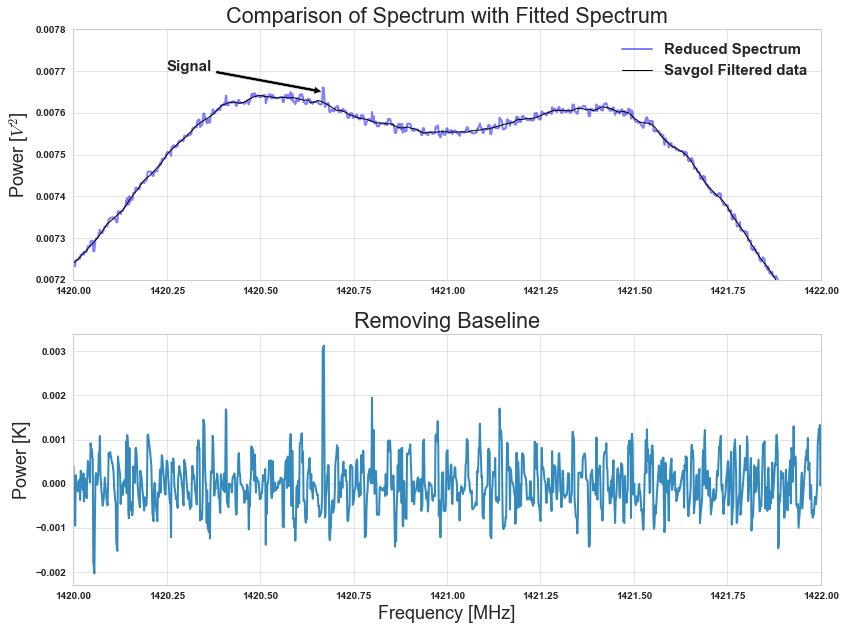

In [984]:
fig = plt.figure(figsize = (12, 9))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.set_title('Comparison of Spectrum with Fitted Spectrum')
ax1.plot(freq[0], spec[0], 'b-', alpha =.5, linewidth = 2, label = 'Reduced Spectrum', )
ax1.plot(freq[0], Fit_data[0], 'k-',  linewidth = 1, label = 'Savgol Filtered data')
#ax1.set_xlabel('Frequency [MHz]')
ax1.set_ylabel(r'Power [$V^2$]')
ax1.set_xlim(1420, 1422)
ax1.set_ylim(.0072, .0078)
#ax1.set_xlabel('Frequency [MHz]')
#plt.axvline(1420.67)
ax1.annotate('Signal', xy = (1420.67, .00765), xytext=(1420.25, .0077), 
             arrowprops=dict(arrowstyle="simple", facecolor='black'))
ax1.legend(fontsize = 15)


ax2.set_title('Removing Baseline')
ax2.plot(freq[0], 86.86991922002115*spec_data[0])
ax2.set_xlabel('Frequency [MHz]')
ax2.set_ylabel('Power [K]')
ax2.set_xlim(1420, 1422)
plt.tight_layout()
plt.savefig('Plots.pdf')

ME TESTING THE NP.APPEND FUNCTION AND HOW TO USE IT

In [775]:

y = np.array([[1,2],[3,4],[5,6]])
#print(coord)

x = np.append(y, np.array([12,12]))


In [781]:
z = np.split(x, len(x)/2)
print(z)

[array([1, 2]), array([3, 4]), array([5, 6]), array([12, 12])]


FUNCTIONS TO BE USED ON THE FITS FILES I HAVE IN THIS DIRECTORY

In [1008]:
def coordinates(file):
    
    y = list(coord)
    for i in file:
        
        x = i.split('.')
        
        l = x[2]
        b = x[4]
        
        coor = np.array([l,b])
        
        y.append(coor)
        
    return y    

#COLLECTS DATA 
def da(file):
    l = list(spec)
    
    for i in file:
        hdu = fits.open(i)
        spectrum = data(hdu)
        
        l.append(spectrum)
        hdu.close()
        
    return l

#COLLECTS THE RA AND DEC
def radec(file):
    
    f = list(RA_DEC)
    j = list(JD)
    
    for i in file:
        hdu = fits.open(i)
        
        RA = hdu[0].header['RA']
        DEC = hdu[0].header['DEC']
        Jd = hdu[0].header['JD']
        
        f.append([RA, DEC])
        j.append(Jd)
        
    return f, j     

GETS THE RA, DEC AND JD FROM THE FITS FILE DATA AND APPENDS IT TO THE ARRAY NAMED ABOVE

In [810]:
RA_DEC, JD = radec(spec_files)

GETTING COORDINATES AND DATA

In [788]:
co = coordinates(spec_files)
v = da(spec_files)

In [669]:
fit = savgol_filter(spec[331], 171, 1)

FUNCTION THAT CENTERS THE DATA AND GETS RID OF THE BASELINE

In [685]:
def center_spec(data):
    new_spec = []
    fit_S = []
    for i in range(len(data)):
        fit = savgol_filter(data[i], 51, 3)
        spec = data[i]-fit
        fit_S.append(fit)
        
        for l in range(len(spec)):
            
            if l <=200 or l >= 8000:
                spec[l] = np.nan
                
            #if freq[i][l] <= 1424:
             #   spec[l] = np.nan
            #if freq[i][l] >= 1424.85:
             #   spec[l] = np.nan
                
        new_spec.append(spec)  
        
        
        
    return np.array(new_spec), np.array(fit_S)  

In [796]:
#v IS THE DATA HAVING ALL THE AVERAGED SPECTRA
spec_data, Fit_data = center_spec(v)

CODE BELOW FINDS THE PEAK OF OUR SPECTRUM AND RETURNS US THE CORRESPONDING FREQUENCY 

In [798]:
ind = []
freq_peak = []
for i in range(len(spec_data)):
    index = np.nanargmax(spec_data[i])
    #plt.plot(freq[i], 10000*spec_data[i])
    #plt.xlim(1418, 1425.5)
    ind.append(index)
    freq_peak.append(freq[0][index])
freq_arr = np.array(freq_peak)    

CODE BELOW SHIFTS IT DOWN BECAUSE SOME OF OUR OBSERVATIONS WERE DONE AT AN LO OF 633 INSTEAD OF 635

In [799]:
for i in range(len(freq_peak)):
    if freq_peak[i] >1424:
        freq_peak[i] -= 4
    if freq_peak[i] < 1419:
        freq_peak[i] = 0

FUNCTION THAT CALULATES THE DOPPLER VELOCITY OF THE PEAK GIVEN THE FREQUENCY OF THE PEAK FOUND ABOVE

In [813]:
def doppler(freq, RA_DEC, JD):
    
    dopp = []
    #spec_val = []
    #plt.figure(figsize = (12,8))    
        
      
    #plt.figure(figsize = (12,8))
    for i in range(len(RA_DEC)): 
        
        nu = 1420.405751786e6 #Hz
        if freq[i] != 0:
            delta_nu = freq[i]*1e6 - nu

            c = 3 * (10**8)
            v = -(delta_nu / nu) * c

            RA = RA_DEC[i][0]
            DEC = RA_DEC[i][1]
            Jd = JD[i]
            doppler_v = get_projected_velocity(RA, DEC, Jd)
            dop_vel = (v - doppler_v)/1000 #converts to km

            #index = np.nanargmax(spec_data[i])

            dopp.append(dop_vel)
        else:
            dopp.append(0)
        #spec_val.append(spec_data[i][index])
        
        #plt.plot(dop_vel, spec_data[i])
        #plt.axvline(dop_vel[index])
    
    return np.array(dopp)#, np.array(spec_val)

        

In [814]:
dop_vel = doppler(freq_peak, RA_DEC, JD)

In [815]:
for i in range(len(dop_vel)):
    print(dop_vel[i], freq_peak[i], co[i])

[-74.59485642] 1420.6702478329873 [ 60. -80.]
[-75.18797699] 1420.6673177878158 [ 60. -76.]
[-76.92116556] 1420.6702478329873 [ 60. -72.]
[-77.31364923] 1420.6673177878158 [ 60. -68.]
[-78.8359401] 1420.6702478329873 [ 60. -64.]
[-79.00824806] 1420.6673177878158 [ 60. -60.]
[-80.30216152] 1420.6702478329873 [ 60. -56.]
[-80.23906671] 1420.6673177878158 [ 60. -52.]
[-62.93251974] 1420.5833231595655 [ 60. -48.]
[-66.33640926] 1420.597973385423 [ 60. -44.]
[-66.8300002] 1420.5994384080088 [ 60. -40.]
[-69.98196652] 1420.6140886338665 [ 60. -36.]
[-63.10583523] 1420.5818581369797 [ 60. -32.]
[-63.53444689] 1420.586253204737 [ 62. -30.]
[-59.3446729] 1420.5657428885363 [ 62. -34.]
[-80.81569714] 1420.6673177878158 [ 62. -38.]
[-65.75338528] 1420.5965083628373 [ 62. -42.]
[-55.62109494] 1420.5496276400927 [ 62. -46.]
[-80.74340084] 1420.6702478329873 [ 62. -50.]
[-79.64996301] 1420.6673177878158 [ 62. -54.]
[-57.91274301] 1420.567207911122 [ 62. -58.]
[-78.96645558] 1420.6702478329873 [ 62. 

In [816]:
np.amax(dop_vel)

array([255.66085159])

In [817]:
np.amin(dop_vel)

array([-527.93972172])

CODE BELOW IS THE MAPPING ALGORITHM I USED TO MAP THE DOPPLER VELOCITY TO COLOR

In [1]:
#MAKING A MATRIX
matrix = np.zeros((31,26,3), dtype = int)

#r_img = img[:,:,0]
#g_img = img[:,:,1]
#b_img = img[:,:,2]

N = 0


for i in range(len(coord)):
    
    l = float(coord[i][0])
    b = float(coord[i][1])

    #col = np.linspace(0, 256, 257)
    #values = np.linspace(-501.82434399395436, -306.08842281913303, 257)

        #psueodo data im trying

        #for loop that ranges through the list of galactic values 
    for m in range(len(lb_val)):

            #if statement that checks to see if the galactic coordinates match up and appends
            #them to the proper index in the matrix
            
        def find_nearest(array, value):
            array = np.asarray(array)
            idx = (np.abs(array - value)).argmin()
            return idx
        #CHECKING TO SEE IF COORDINATES MATCH THE L AND B VALUE FOR THE MATRIX
        if l == lb_val[m][0] and b == lb_val[m][1]:
            #GETS THE INDEXES
            row_index = indexes[m][0]
            column_index = indexes[m][1]

            #GETTING THE CORRESPONDING VELOCITY
            dop = dop_vel[i]
            
            #IF NEGATIVE GO TO THIS CODE BLOCK
            if dop < 0:
                #MAKING A LIST OF INTEGERS FOR COLOR MAPPING
                val = list(reversed(np.arange(0, 256, 1)))
                #THE VELOCITY MAP
                mapp = np.linspace(np.amin(dop_vel), 0, 256)
                
                #GETTING INDEX TO WHERE THE MAPP AND VALUE ARE THE CLOSEST
                indx = find_nearest(mapp, dop)
                
                #GETTING THE CORRESPONDING VALUE FOR THE COLOR
                color = val[indx]
                
                #APPENDING THAT TO THE RED PART OF THE MATRIX
                matrix[row_index, column_index, 0] = int(color)
            
            #IF POSITIVE VELOCITY
            if dop > 0:
                
                #SAME DEAL AS BEFORE BUT NOW WITH POSITIVE MAPPING
                val = np.arange(0, 256, 1)
                mapp = np.linspace(0, np.amax(dop_vel), 256)
                
                indx = find_nearest(mapp, dop)
                
                color = val[indx]
                matrix[row_index, column_index, 2] = int(color)
        
                
#print(matrix)

NameError: name 'np' is not defined

INITIAL TRY TO APPEND THE DATA AUTOMATICALLY BUT CODE ABOVE WORKS JUST FINE

In [594]:
def appending_data(coords, data):
    
    #makes an emptry matrix
    matrix = np.zeros((31,26,3))
    loop = []
    #loops through the filenames of the data that we gathered
    for i in range(len(coords)):
        
        #opens the filename
        #hdu = fits.open(i)
        
        #splits the filename at every period
        #f_split = i.split('.')
        
        #getting only the l and b because that is all that we need and converting them to floats
        l = float(coords[i][0])
        b = float(coords[i][1])
        
        def find_nearest(array, value):
            array = np.asarray(array)
            idx = (np.abs(array - value)).argmin()
            return idx
        
        #psueodo data im trying
        N = 1
        
        #for loop that ranges through the list of galactic values 
        for m in range(len(lb_val)):
            
            #if statement that checks to see if the galactic coordinates match up and appends
            #them to the proper index in the matrix
            if l == lb_val[m][0] and b == lb_val[m][1]:
                #print(l, b)
                loop.append([l,b])
                #print(N)
                #N+=1
                #gets the matrix indices from indexes
                row_index = indexes[m][0]
                column_index = indexes[m][1]
                
                #appending a value to the matrix
                matrix[row_index, column_index] = data[i] #DATA THAT NEEDS TO BE APPENDED TO THE SPECIFIED LOCATION
            
                #updating the psuedo data
            #N+=1
    print(matrix.shape)        
    print(len(loop))    
    return matrix    

806

In [596]:
mat = appending_data(coord, col)

(31, 26, 3)
500


ME MESSING AROUND WITH COUNTOUR PLOT BELOW USING THIS CODE BLOCK WHICH APPENDS THE VELOCITY STRAIGHT TO THE MATRIX

In [822]:
matrix1 = np.zeros((31,26))


N = 0
for i in range(len(coord)):
    
    l = float(coord[i][0])
    b = float(coord[i][1])

    #col = np.linspace(0, 256, 257)
    #values = np.linspace(-501.82434399395436, -306.08842281913303, 257)

        #psueodo data im trying

        #for loop that ranges through the list of galactic values 
    for m in range(len(lb_val)):

            #if statement that checks to see if the galactic coordinates match up and appends
            #them to the proper index in the matrix
            
        def find_nearest(array, value):
            array = np.asarray(array)
            idx = (np.abs(array - value)).argmin()
            return idx
        
        if l == lb_val[m][0] and b == lb_val[m][1]:
            #print(N)
            #N+=1
                #print(l, b)
            #loop.append([l,b])
                #print(N)
                #N+=1
                #gets the matrix indices from indexes
            row_index = indexes[m][0]
            column_index = indexes[m][1]

                #appending a value to the matrix
            dop = dop_vel[i]
            
            
                
            matrix1[row_index, column_index] = dop
        
            
        
                


[[[  0   0   0]
  [ 34   0   0]
  [  0   0   0]
  ...
  [ 13   0   0]
  [ 35   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [ 35   0   0]
  ...
  [  0   0  70]
  [ 13   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [ 35   0   0]
  [  0   0   0]
  ...
  [ 67   0   0]
  [  0   0 140]
  [  0   0   0]]

 ...

 [[  0   0   0]
  [ 29   0   0]
  [  0   0   0]
  ...
  [ 20   0   0]
  [110   0   0]
  [  0   0   0]]

 [[ 30   0   0]
  [  0   0   0]
  [ 39   0   0]
  ...
  [ 22   0   0]
  [ 16   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [ 31   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]


THE FINAL DISPLAY OF THE DOPPLER VELOCITY DISTRIBUTION

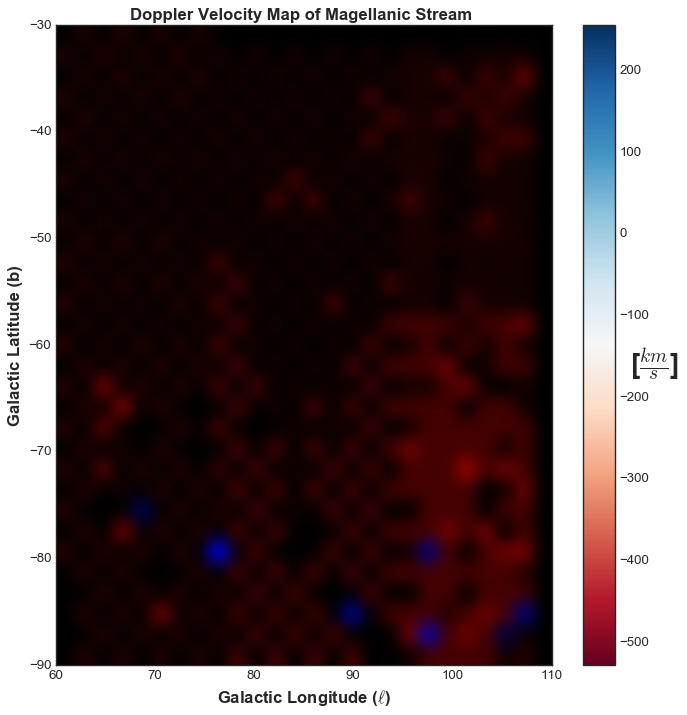

In [1003]:
plt.figure(figsize = (10,10))
plt.title('Doppler Velocity Map of Magellanic Stream ', fontsize = 15, weight = 'semibold')
plt.imshow(matrix, cmap = 'RdBu', interpolation= 'gaussian', aspect = 'auto', origin = 'lower', extent=[60,110,-90,-30], vmin=np.amin(dop_vel), vmax=np.amax(dop_vel))
plt.xlabel(r'Galactic Longitude ($\ell$)', fontsize = 15, weight = 'semibold')
plt.ylabel('Galactic Latitude (b)', fontsize = 15, weight = 'semibold')
cbar = plt.colorbar()
cbar.set_label(r'[$\frac{km}{s}$]', rotation=0, fontsize = 25, fontweight = 'semibold')
plt.savefig('Galactic_Plot.pdf')

ME TRYING TO GET THE BASEMAP PACKAGE AND USE IT

In [416]:
import mpl_toolkits

In [417]:
mpl_toolkits

<module 'mpl_toolkits' (namespace)>

In [873]:
plt.style.use('seaborn-notebook')

In [869]:
plt.style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'tableau-colorblind10',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

MESSING AROUND WITH CONTOUR HERE BUT WE NEED TO HAVE A COMPLETE DATA SET TO USE THIS AND WE DONT

Text(0, 0.5, 'Galactic Latitude (b)')

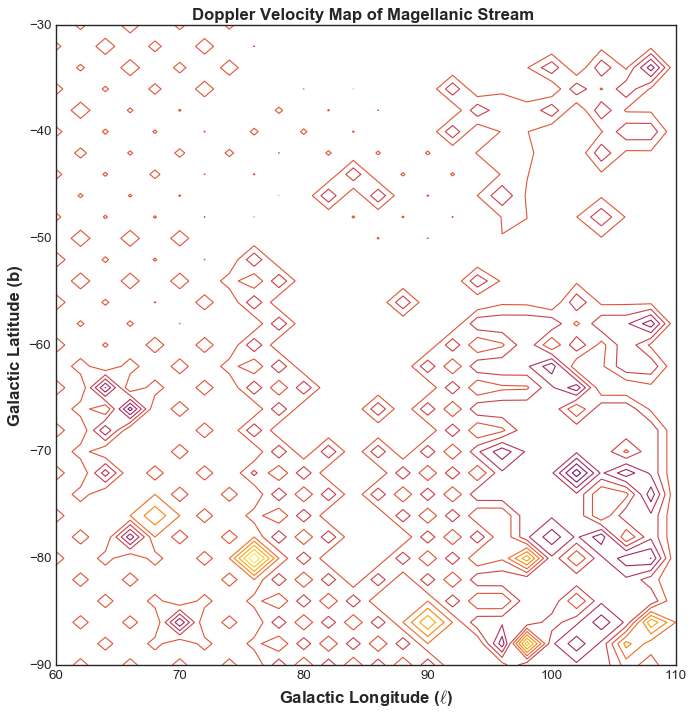

In [995]:
plt.style.use('seaborn-white')
plt.figure(figsize = (10,10))
plt.title('Doppler Velocity Map of Magellanic Stream ', fontsize = 15, weight = 'semibold')
plt.contour(matrix1, levels = np.arange(-400, 300, 50), cmap = 'inferno', extend = 'both', origin = None, extent=[60,110,-90,-30], vmin=np.amin(dop_vel), vmax=np.amax(dop_vel))
plt.xlabel(r'Galactic Longitude ($\ell$)', fontsize = 15, weight = 'semibold')
plt.ylabel('Galactic Latitude (b)', fontsize = 15, weight = 'semibold')
#plt.colorbar()